In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define paths relative to the notebook directory
base_dir = Path.cwd().parent / "simulation_data"

file_paths = [base_dir / f"cdm_and_imem_data_neo_{i}.npy" for i in range(8)]

imem_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in file_paths
]

imem_data = {}
for data in imem_data_list:
    imem_data.update(data)

In [3]:
avg_len_data_celltype = []

def calculate_neuron_type_len_stats(imem_data):
    """Categorizes cells based on their names and calculates the average and standard deviation 
    of len_a and len_b for each frequency within each category.
    Ensures that Spiny Stellate cells are always index 0 in the result list.
    """
    global avg_len_data_celltype

    avg_len_data_celltype = []
    categorized_data = {}

    # --- Organize data by category ---
    for cell_name, data in imem_data.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: 
            cell_category = 'Inhibitory neurons'

        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}

        # Convert to numpy arrays
        len_a = np.array(data['avg_return_pos_above_soma'])
        len_b = np.array(data['avg_return_pos_below_soma'])

        # Distribute values into frequency buckets
        for freq, a_val, b_val in zip(data['frequency'], len_a, len_b):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = {'len_a': [], 'len_b': []}
            
            categorized_data[cell_category][freq]['len_a'].append(a_val)
            categorized_data[cell_category][freq]['len_b'].append(b_val)

    # --- Define fixed category order ---
    category_order = ['Spiny Stellate cells', 'Pyramidal cells', 'Inhibitory neurons']

    # --- Compute averages and standard deviations in fixed order ---
    for category in category_order:
        if category not in categorized_data:
            continue  # Skip if category has no data

        freq_data = categorized_data[category]
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'avg_len_a': [],
            'std_len_a': [],
            'avg_len_b': [],
            'std_len_b': []
        }

        for freq, values in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['avg_len_a'].append(np.nanmean(values['len_a']))
            category_result['std_len_a'].append(np.nanstd(values['len_a']))
            category_result['avg_len_b'].append(np.nanmean(values['len_b']))
            category_result['std_len_b'].append(np.nanstd(values['len_b']))

        avg_len_data_celltype.append(category_result)


In [8]:
def print_avg_len_at_frequency(avg_len_data_celltype, target_freq):
    """Prints avg len_a and len_b at the closest frequency to target_freq for each cell type."""
    for cell_data in avg_len_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = np.array(cell_data['frequencies'])
        avg_len_a = np.array(cell_data['avg_len_a'])
        avg_len_b = np.array(cell_data['avg_len_b'])

        # Find closest frequency index
        idx = (np.abs(frequencies - target_freq)).argmin()
        closest_freq = frequencies[idx]

        print(f"Cell type: {cell_category}")
        print(f"  Closest frequency: {closest_freq} Hz")
        print(f"  Avg len_a: {avg_len_a[idx]:.3f} µm")
        print(f"  Avg len_b: {avg_len_b[idx]:.3f} µm")
        print("-" * 40)

In [9]:
def mark_subplots(axes, letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ', xpos=-0.12, ypos=1.15, fontsize = 10):

    if not type(axes) is list:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.text(xpos, ypos, letters[idx].capitalize(),
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=fontsize,
                transform=ax.transAxes)

In [10]:
def plot_combined_avg_and_celltype(data_dict, avg_len_data_celltype):
    """
    Creates a figure with two subplots:
    1) Per-cell traces of average return positions (above/below soma).
    2) Cell-type averages of len_a and len_b with std shading.
    """

    # --- Setup figure with two subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))  # wider for side-by-side
    plt.rcParams['mathtext.fontset'] = 'stix'
    ax1, ax2 = axes

    max_pos_above_all = 0
    max_pos_below_all = 0
    max_avg_len_a = 0
    max_avg_len_b = 0

    # ========== LEFT PLOT: per-cell traces ==========
    for i, cell_name in enumerate(data_dict.keys()):
        cell_info = data_dict[cell_name]
        if 'PC' in cell_name or 'SP' in cell_name:
            colors = 'tab:green'
            labels = 'PC cell'
            alphas = 0.6
            linewidth = 1
        elif 'SS' in cell_name:
            colors = 'tab:purple'
            labels = 'SS cell'
            alphas = 1
            linewidth = 1.5
        else: 
            colors = 'tab:orange'
            labels = 'Inhb cell'
            alphas = 0.15
            linewidth = 1
        
        frequency = cell_info['frequency']
        avg_pos_above = cell_info['avg_return_pos_above_soma']
        avg_pos_below = cell_info['avg_return_pos_below_soma']

        if np.max(avg_pos_above[:-1]) > max_pos_above_all:
            max_pos_above_all = np.max(avg_pos_above[:-1])
        if np.max(np.abs(avg_pos_below[:-1])) > max_pos_below_all:
            max_pos_below_all = np.max(np.abs(avg_pos_below[:-1]))
        
        if len(frequency) != len(avg_pos_above) or len(frequency) != len(avg_pos_below):
            print(f"Warning: Skipping {cell_name} due to mismatched data lengths.")
            continue

        ax1.semilogx(frequency[:-1], avg_pos_above[:-1], 
                     label=f'{labels} (Above Soma)', 
                     color=colors, linestyle='-', 
                     alpha=alphas, linewidth=linewidth)
        
        ax1.semilogx(frequency[:-1], avg_pos_below[:-1], 
                     label=f'{labels} (Below Soma)', 
                     color=colors, linestyle='--', 
                     alpha=alphas, linewidth=linewidth)
    
    # --- Marking example cells ---
    # for i, cell_name in enumerate(data_dict.keys()):
    #     if cell_name in ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]:
    #         cell_info = data_dict[cell_name]
    #         frequency = cell_info['frequency']
    #         avg_pos_above = cell_info['avg_return_pos_above_soma']
    #         avg_pos_below = cell_info['avg_return_pos_below_soma']
    #         ax1.semilogx(frequency[:-1], avg_pos_above[:-1], label=f'{labels} (Above Soma)', color='black', linestyle='-', alpha=1, linewidth=1)
    #         ax1.semilogx(frequency[:-1], avg_pos_below[:-1], label=f'{labels} (Below Soma)', color='black', linestyle='--', alpha=1, linewidth=1)         

    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Average $I_\mathrm{m}$ position (µm)', fontsize = 9)
    ax1.set_title('All neocortical neurons', fontsize = 10)

    ax1.set_xlim(left=1, right=2000)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax1.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.8)
    ax1.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.8)

    # Custom legend for subplot 1
    # custom_legend = [
    #     Line2D([0], [0], color='tab:green', lw=2, label='Pyramidal cells (Above Soma)', alpha=1),
    #     Line2D([0], [0], color='tab:purple', lw=2, label='Spiny Stellate cells (Above Soma)', alpha=1),
    #     Line2D([0], [0], color='tab:orange', lw=2, label='Inhibitory neurons (Above Soma)', alpha=1),
    #     Line2D([0], [0], color='tab:green', lw=2, label='Pyramidal cells (Below Soma)', alpha=1, linestyle='--'),
    #     Line2D([0], [0], color='tab:purple', lw=2, label='Spiny Stellate cells (Below Soma)', alpha=1, linestyle='--'),
    #     Line2D([0], [0], color='tab:orange', lw=2, label='Inhibitory neurons (Below Soma)', alpha=1, linestyle='--'),
    # ]
    # ax1.legend(handles=custom_legend, loc='lower right', fontsize=8, ncol = 3)

    # ========== RIGHT PLOT: cell-type averages ==========
    for cell_data in avg_len_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = np.array(cell_data['frequencies'])
        avg_len_a = np.array(cell_data['avg_len_a'])
        std_len_a = np.array(cell_data['std_len_a'])
        avg_len_b = np.array(cell_data['avg_len_b'])
        std_len_b = np.array(cell_data['std_len_b'])

        if np.max((avg_len_a + std_len_a)[:-1]) > max_avg_len_a:
            max_avg_len_a = np.max((avg_len_a + std_len_a)[:-1]) 
        if np.max(np.abs((avg_len_b + std_len_b)[:-1])) > max_avg_len_b:
            max_avg_len_b = np.max(np.abs((avg_len_b + std_len_b)[:-1]))

        if cell_category == 'Pyramidal cells':
            color = 'tab:green'
        elif cell_category == 'Spiny Stellate cells':
            color = 'tab:purple'
        else:
            color = 'tab:orange'

        ax2.semilogx(frequencies[:-1], avg_len_a[:-1], linestyle='-', 
                     label=f'{cell_category} (Above Soma)', color=color)
        ax2.fill_between(frequencies[:-1],
                         (avg_len_a - std_len_a)[:-1], (avg_len_a + std_len_a)[:-1],
                         color=color, alpha=0.2)

        ax2.semilogx(frequencies[:-1], avg_len_b[:-1], linestyle='--', 
                     label=f'{cell_category} (Below Soma)', color=color)
        ax2.fill_between(frequencies[:-1],
                         (avg_len_b - std_len_b)[:-1], (avg_len_b + std_len_b)[:-1],
                         color=color, alpha=0.2)

    ax2.set_xlabel('Frequency [Hz]')
    #ax2.set_ylabel('Average $I_\mathrm{m}$ return position (µm)')
    ax2.set_title('Neuron-type averages', fontsize = 10)
    ax2.set_xlim(left=frequencies[0], right=2000)
    ax2.set_ylim()

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax2.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.8)
    ax2.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.8)


    max_y_all = max(max_pos_above_all, max_pos_below_all)
    y_marg_all = 0.05 * max_y_all
    ylim_all = max_y_all + y_marg_all
    max_y_avg = max(max_avg_len_a, max_avg_len_b)
    y_marg_avg = 0.05 * max_y_avg
    ylim_avg = max_y_avg + y_marg_avg

    ax1.set_ylim(0-ylim_all, 0+ylim_all)
    ax2.set_ylim(0-ylim_avg, 0+ylim_avg)

    # handles, labels = ax2.get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # ax2.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=3)

    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=3, frameon=False, loc='center', bbox_to_anchor=(0.5, -0.05))

    # --- Final layout ---
    mark_subplots(fig.axes, ypos=1.1, fontsize = 12)
    plt.tight_layout()
    plt.show()


<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_49427/383965372.py:71: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Average $I_\mathrm{m}$ position (µm)', fontsize = 9)


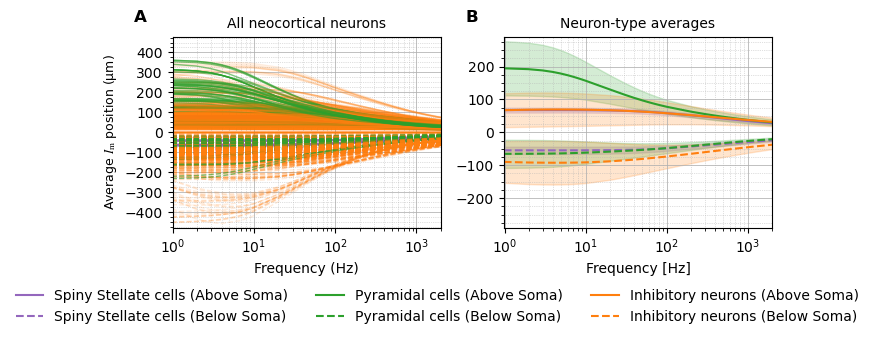

In [11]:
calculate_neuron_type_len_stats(imem_data)
plot_combined_avg_and_celltype(imem_data, avg_len_data_celltype)

In [12]:
print_avg_len_at_frequency(avg_len_data_celltype, target_freq = 1000)

Cell type: Spiny Stellate cells
  Closest frequency: 999.9961853172863 Hz
  Avg len_a: 34.423 µm
  Avg len_b: -29.739 µm
----------------------------------------
Cell type: Pyramidal cells
  Closest frequency: 999.9961853172863 Hz
  Avg len_a: 37.933 µm
  Avg len_b: -26.379 µm
----------------------------------------
Cell type: Inhibitory neurons
  Closest frequency: 999.9961853172863 Hz
  Avg len_a: 37.618 µm
  Avg len_b: -45.367 µm
----------------------------------------
